Using device: cpu
Classes: ['NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']


C:\Users\User\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/20
train Loss: 0.3523 Acc: 0.8618 F1: 0.8717
val Loss: 0.2299 Acc: 0.9087 F1: 0.9124

Epoch 2/20
train Loss: 0.2534 Acc: 0.8929 F1: 0.9007
val Loss: 0.1833 Acc: 0.9270 F1: 0.9322

Epoch 3/20
train Loss: 0.2233 Acc: 0.9046 F1: 0.9118
val Loss: 0.2987 Acc: 0.8345 F1: 0.8501

Epoch 4/20
train Loss: 0.2210 Acc: 0.9037 F1: 0.9109
val Loss: 0.2567 Acc: 0.8754 F1: 0.8812

Epoch 5/20
train Loss: 0.2071 Acc: 0.9077 F1: 0.9149
val Loss: 0.1731 Acc: 0.9257 F1: 0.9316

Epoch 6/20
train Loss: 0.1923 Acc: 0.9146 F1: 0.9210
val Loss: 0.1853 Acc: 0.9207 F1: 0.9261

Epoch 7/20
train Loss: 0.1915 Acc: 0.9157 F1: 0.9222
val Loss: 0.1797 Acc: 0.9232 F1: 0.9282
⏹️ Early stopping triggered
Training complete. Best val Acc: 0.9270


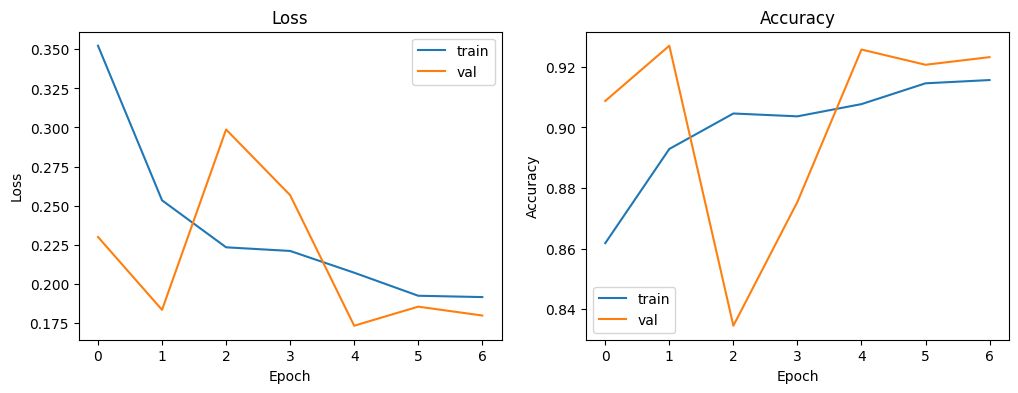

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os

# Config
data_dir = r"C:\Users\User\Desktop\Medical-Image-Classification\data"
batch_size = 16
num_epochs = 20
learning_rate = 0.0005
patience = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data Transforms
transform = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(0, translate=(0.1,0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

# Datasets & Dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x), transform=transform[x]) 
                  for x in ["train","val","test"]}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) 
               for x in ["train","val","test"]}

class_names = image_datasets["train"].classes
print("Classes:", class_names)

# Model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Loss & Optimizer
labels = image_datasets["train"].targets
class_counts = np.bincount(labels)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}
best_acc = 0.0
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for phase in ["train","val"]:
        if phase=="train":
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for inputs, labels_batch in dataloaders[phase]:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase=="train"):
                outputs = model(inputs)
                loss = criterion(outputs, labels_batch)
                _, preds = torch.max(outputs, 1)
                
                if phase=="train":
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item()*inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
        
        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average="weighted")
        
        history[f"{phase}_loss"].append(epoch_loss)
        history[f"{phase}_acc"].append(epoch_acc)
        history[f"{phase}_f1"].append(epoch_f1)
        
        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")
        
        if phase=="val":
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), "best_model.pth")
                patience_counter = 0
            else:
                patience_counter +=1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered")
                break
    
    if patience_counter>=patience:
        break

print("Training complete. Best val Acc: {:.4f}".format(best_acc))

# Plot Metrics
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"], label="val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


Using device: cpu
Classes: ['NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']


C:\Users\User\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



=== Train Set Metrics ===
Accuracy: 0.9286
F1-score: 0.9343
Precision: 0.9507
Recall: 0.9286

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.88      0.93      3942
   PNEUMONIA       0.97      0.99      0.98      2991
TUBERCULOSIS       0.55      0.97      0.70       489

    accuracy                           0.93      7422
   macro avg       0.83      0.94      0.87      7422
weighted avg       0.95      0.93      0.93      7422



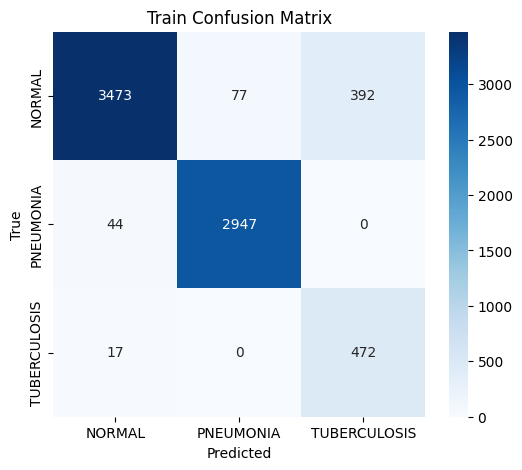


=== Validation Set Metrics ===
Accuracy: 0.9270
F1-score: 0.9322
Precision: 0.9478
Recall: 0.9270

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.88      0.93       844
   PNEUMONIA       0.97      0.98      0.98       640
TUBERCULOSIS       0.55      0.96      0.70       105

    accuracy                           0.93      1589
   macro avg       0.83      0.94      0.87      1589
weighted avg       0.95      0.93      0.93      1589



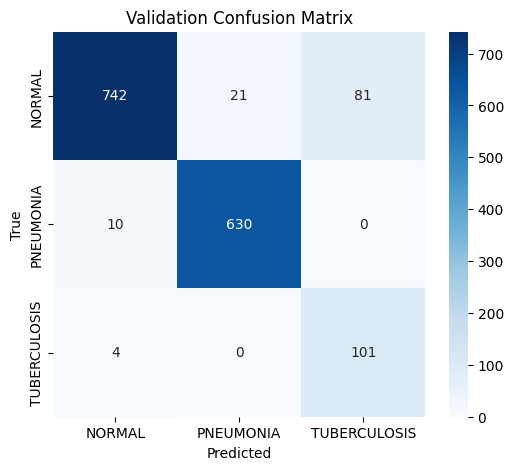


=== Test Set Metrics ===
Accuracy: 0.9316
F1-score: 0.9367
Precision: 0.9513
Recall: 0.9316

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.89      0.93       846
   PNEUMONIA       0.98      0.98      0.98       642
TUBERCULOSIS       0.56      0.96      0.71       106

    accuracy                           0.93      1594
   macro avg       0.84      0.94      0.87      1594
weighted avg       0.95      0.93      0.94      1594



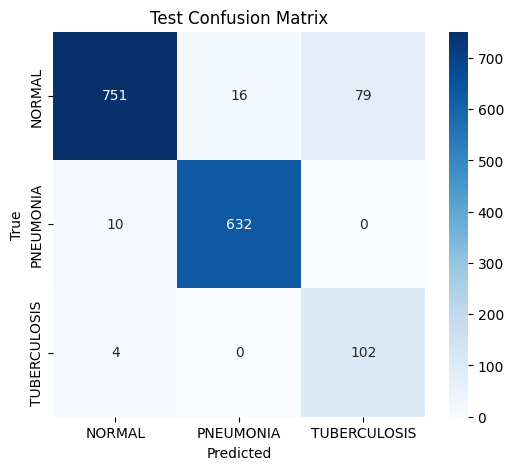

In [3]:
#Imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

#Config
data_dir = r"C:\Users\User\Desktop\Medical-Image-Classification\data"
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Data Transforms
transform = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

#Datasets & Dataloaders
datasets_dict = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transform[x])
                 for x in ["train","val","test"]}

dataloaders = {x: DataLoader(datasets_dict[x], batch_size=batch_size, shuffle=False)
               for x in ["train","val","test"]}

class_names = datasets_dict["train"].classes
print("Classes:", class_names)

#Load Model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

#Load the trained weights
model_path = "best_model.pth"
assert os.path.exists(model_path), f"Model not found at {model_path}"
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

#Evaluation Function
def evaluate_model(model, dataloader, class_names, set_name="Set"):
    all_labels, all_preds = [], []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    #Metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")

    print(f"\n=== {set_name} Set Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


    #Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{set_name} Confusion Matrix")
    plt.show()

    return all_labels, all_preds

#Evaluate All Sets
train_labels, train_preds = evaluate_model(model, dataloaders['train'], class_names, set_name="Train")
val_labels, val_preds = evaluate_model(model, dataloaders['val'], class_names, set_name="Validation")
test_labels, test_preds = evaluate_model(model, dataloaders['test'], class_names, set_name="Test")


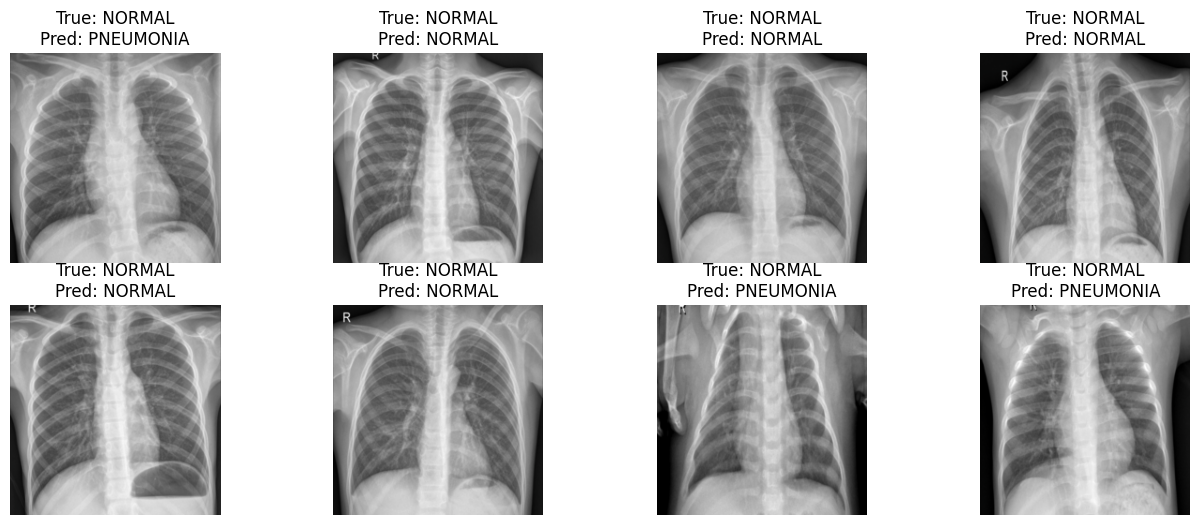

In [6]:
# Sample Predictions on Test Images
import random

# Get a batch of test data
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Move to CPU for visualization
images = images.cpu().numpy()
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()

# Plot first 8 images with predictions
plt.figure(figsize=(16,6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = images[i].transpose((1,2,0))
    # Unnormalize
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
    plt.axis('off')
plt.show()


In [5]:
# Model Architecture Summary
from torchsummary import summary

# For input size 3x224x224 (RGB images)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,